Hello,

Below is an implementation of two path finding algorithms in a 2D space around various obstacles. The first implentation uses a bug algorithm while the second utilizes gradient descent to find an optimal path. Scroll down to see my results.

In [1]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from math import hypot
import math
from scipy import optimize

In [2]:
X = np.arange(-10, 10.1, 0.1)
Y = np.arange(-10, 10.1, 0.1)
#print(X)
X, Y = np.meshgrid(X, Y)
Q_START = np.array([-9,0])
Q_GOAL = np.array([9,0]) 

def gradient_descent(obstacles, kappa, eps):
    
    path = []
    path.append(Q_START)
    q_curr = np.array([-9,0])
    curr_gradient = optimize.approx_fprime(q_curr, calculate_potential, eps, kappa)
    while np.linalg.norm(curr_gradient) > eps*100:
        curr_gradient_hat = curr_gradient / np.linalg.norm(curr_gradient)
        q_curr = q_curr - 0.1*curr_gradient_hat
        path.append(q_curr)
        curr_gradient = optimize.approx_fprime(q_curr, calculate_potential, eps, kappa)

    return path

#https://www.knowledgehut.com/blog/programming/python-rounding-numbers
def round_up(n, decimals=0): 
    multiplier = 10 ** decimals 
    return math.ceil(n * multiplier) / multiplier


def calculate_potential(q_curr, kappa):
    x_cor = q_curr[0]
    y_cor = q_curr[1]
    config_type = get_config_type(x_cor, y_cor)
    if config_type == 3: #on the goal
        return 0
    elif config_type == 2: #inside obstacle or out of bounds
        return 1
    
    beta = calculate_beta(x_cor, y_cor, obstacles)
    phi = calculate_phi(x_cor, y_cor, beta, kappa)
    return phi 

def get_config_type(x_cor, y_cor):
    if x_cor ==  Q_GOAL[0] and y_cor == Q_GOAL[1]:
        return 3 #cords on the goal
    if hypot(x_cor, y_cor) >= 10:
        return 2 #cords out of bounds 
    for obstacle in obstacles:
        if hypot(x_cor-obstacle[0][0], y_cor-obstacle[0][1]) < obstacle[1]:
            return 2 #cords inside an obstacle
    return 1 #cords anywhere else
            
def calculate_beta(x_cor, y_cor, obstacles):
    result = -(hypot(x_cor, y_cor)**2)+10**2
    for obstacle in obstacles:
        dist_to_obs = abs(hypot(x_cor-obstacle[0][0], y_cor-obstacle[0][1]) - obstacle[1])
        result = result*(dist_to_obs**2 - obstacle[1]**2)
    return result

def calculate_phi(x_cor, y_cor, beta, kappa):
    dist_to_goal = abs(hypot(x_cor-Q_GOAL[0], y_cor-Q_GOAL[1]))
    denominator = (dist_to_goal**(2*kappa) + beta)**(1/kappa)
    return (dist_to_goal**2)/denominator

#I didn't end up using this code :(. Can be ignored for 4.2
def initialize_potentials(kappa, obstacles):
    potentials = np.zeros(shape=(len(X), len(Y)))
    for i in range(0, len(potentials)):
        for j in range(0, len(potentials[0])):
            x_cor = X[i][j]
            y_cor = Y[i][j]
            potentials[i][j] = calculate_potential((x_cor, y_cor), kappa)
    return potentials
    

In [6]:
#https://stackoverflow.com/questions/31735499/calculate-angle-clockwise-between-two-points
def calculate_obstacle_traversal(obstacle, hit_point, leave_point):
    center_x = obstacle[0][0]
    center_y = obstacle[0][1]
    radius = obstacle[1]
    obstacle_traversal = []
    angle = np.arctan2(hit_point[1]-center_y, hit_point[0]-center_x)
    new_point = (center_x + radius * np.cos(angle), center_y + radius * np.sin(angle))
    obstacle_traversal.append(new_point)
    is_left = np.random.randint(2)
    
    while hypot(new_point[0]-leave_point[0], new_point[1]-leave_point[1]) > 0.1:
        if is_left == 1:
            angle -= np.pi/32
        else:
            angle += np.pi/32                
        new_point = (center_x + radius * np.cos(angle), center_y + radius * np.sin(angle))
        obstacle_traversal.append(new_point)
        #x0 + d*cos(theta_rad), y0 + d*sin(theta_rad)
    
    obstacle_traversal.append(leave_point)
    return obstacle_traversal
    
def bug_algorithm(obstacles):
    q_start = (-9,0)
    q_curr = (-9, 0)
    q_goal = (9,0)
    obstacle_intersections = []
    path = []
    
    for obstacle in obstacles:
        if abs(obstacle[0][1]) < obstacle[1]: #if the y axis is less than the radius, then it intersects
            x_away = np.sqrt(obstacle[1]**2 - obstacle[0][1]**2)
            hit_point = (obstacle[0][0] - x_away, 0)
            leave_point = (obstacle[0][0] + x_away, 0)
            obstacle_traversal = calculate_obstacle_traversal(obstacle, hit_point, leave_point)
            obstacle_intersections.append(obstacle_traversal)


    while hypot(q_curr[0]-q_goal[0], q_curr[1]-q_goal[1]) > 0.1: #stepping through the grid
        path.append(q_curr)
        q_curr = (q_curr[0]+0.1, q_curr[1])
        for obstacle in obstacle_intersections:
            if abs(obstacle[0][0] - q_curr[0]) < 0.1:
                path.extend(obstacle)
                q_curr = path[len(path)-1]
                obstacle_intersections.remove(obstacle)
                break
    
    path.append(q_goal)
    return path

Below is an exmaple of using a simple bug algorithm to traverse the environment. 

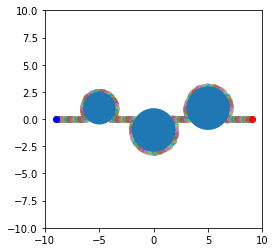

In [7]:
figure, axes = plt.subplots()
axes.set_aspect(1)
plt.plot([-9], [0], 'bo') #start
plt.plot([9], [0], 'ro') #end
obstacles = [((-5,1),1.5), ((0,-1),2), ((5,1),2)]
for obstacle in obstacles:
    axes.add_artist(plt.Circle(obstacle[0], obstacle[1]))
plt.axis([-10, 10, -10, 10])

the_path = bug_algorithm(obstacles)
for point in the_path:
    plt.scatter(point[0],point[1], alpha=0.5)
plt.show()


Here is an example of the bug using gradient descent to path around the obstacles.

Kappa = 1


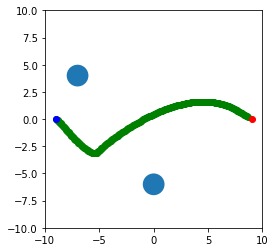

In [3]:
obstacles = [((-7,4),1), ((0,-6),1)]
#eps taken from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html
eps = np.sqrt(np.finfo(float).eps)
print("Kappa = 1")
path = gradient_descent(obstacles, 1, eps)
#print(path)

figure, axes = plt.subplots()
axes.set_aspect(1)
plt.plot([-9], [0], 'bo') #start
plt.plot([9], [0], 'ro') #end
for obstacle in obstacles:
    axes.add_artist(plt.Circle(obstacle[0], obstacle[1]))
plt.axis([-10, 10, -10, 10])

for point in path:
    plt.scatter(point[0], point[1], c='g')
plt.show()


Here is an example of the bug getting stuck in a local minimum. 

Kappa = 1


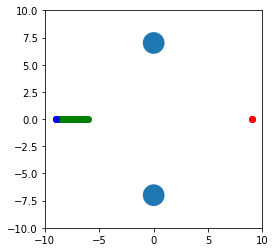

In [5]:
obstacles = [((0,7),1), ((0,-7),1)]
#eps taken from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html
eps = np.sqrt(np.finfo(float).eps)
path = gradient_descent(obstacles, 1, eps)
print("Kappa = 1")

figure, axes = plt.subplots()
axes.set_aspect(1)
plt.plot([-9], [0], 'bo') #start
plt.plot([9], [0], 'ro') #end
for obstacle in obstacles:
    axes.add_artist(plt.Circle(obstacle[0], obstacle[1]))
plt.axis([-10, 10, -10, 10])

for point in path:
    plt.scatter(point[0], point[1], c='g')
plt.plot([-9], [0], 'bo') #start
plt.plot([9], [0], 'ro') #end

plt.show()